In [238]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error

In [7]:
datos = pd.read_csv('../PREDICTIVO.csv',sep=';')

## Exploración de los datos

In [9]:
datos.head(3)

,Anio,MES,AnioMes,PKID,CantidadVentaMes
0,2019,5,2019-05,B2B0130001,2967.0
1,2019,6,2019-06,B2B0130001,3470.0
2,2019,7,2019-07,B2B0130001,4786.0


In [10]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130658 entries, 0 to 130657
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Anio              130658 non-null  int64  
 1   MES               130658 non-null  int64  
 2   AnioMes           130658 non-null  object 
 3   PKID              130658 non-null  object 
 4   CantidadVentaMes  130658 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.0+ MB


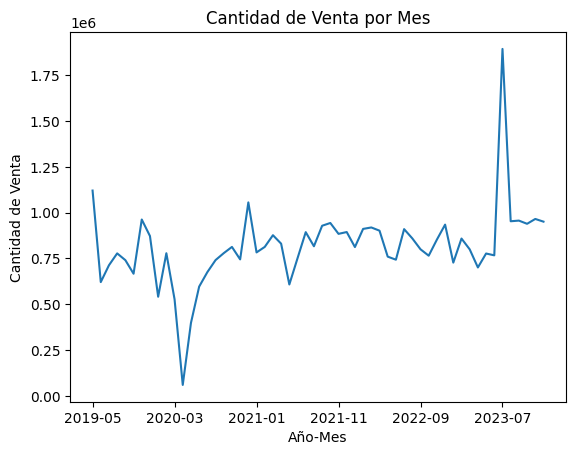

In [32]:
plot = datos.groupby("AnioMes")["CantidadVentaMes"].sum().plot()
# Añadir título y etiquetas de los ejes
plot.set_title("Cantidad de Venta por Mes")
plot.set_xlabel("Año-Mes")
plot.set_ylabel("Cantidad de Venta")

# Mostrar el gráfico
plt.show()

- A lo largo del periodo de mayo de 2019 a julio de 2023, la cantidad de ventas por mes se mantiene relativamente estable.
- Desde mayo de 2019 hasta principios de 2020, hay fluctuaciones notables con varios picos y valles, sugiriendo una alta variabilidad en las ventas durante este periodo.
- Hay una caída abrupta a principios de 2020, probablemente relacionada con el impacto de la pandemia de COVID-19.
- En 2023, hay un pico muy alto en las ventas, seguido de una rápida disminución. Pareciera a causa de un evento o una promoción significativa que impulsó temporalmente las ventas.
- Después de este último pico pareciera estabilizarse con un leve aumento en ventas




## 3 PKID para visualizar
Se escogerá estos 3 PKID al azar estos y se procede a visualizar las ventas mensuales en los últimos 3 años

In [73]:
random.seed(40)
pkid_esco = random.sample(list(datos["PKID"].unique()), 3)
pkid_esco

['B2B0276136', 'B2C0972712', 'B2C1373778']

In [74]:
datos_esco = datos[datos["PKID"].isin(pkid_esco)]
datos_esco = datos_esco.groupby(["AnioMes", "PKID"])["CantidadVentaMes"].sum().reset_index()

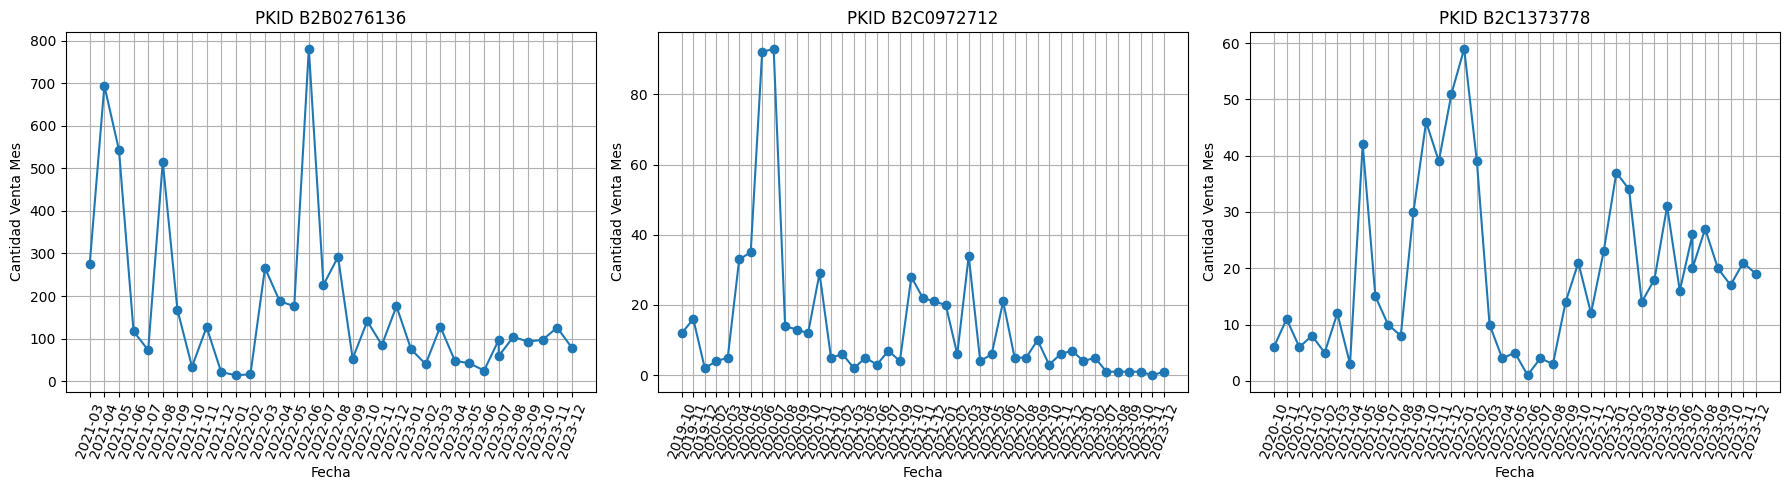

In [75]:
# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Generar gráficos para cada categoría
for i, pkid in enumerate(pkid_esco):
    ax = axes[i]
    df_filtered = datos[datos['PKID'] == pkid]
    ax.plot(df_filtered['AnioMes'], df_filtered['CantidadVentaMes'], marker='o')
    ax.set_title(f'PKID {pkid}')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Cantidad Venta Mes')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=70)  

plt.tight_layout()
plt.show()

#### Gráfico 1: PKID B280276136
- La tendencia general muestra una alta variabilidad inicial con picos significativos, seguidos de una estabilización en niveles más bajos.
- La estabilización indica que el mercado puede haber alcanzado un nuevo equilibrio después de los eventos iniciales que causaron la alta variabilidad.
#### Gráfico 1: PKID B2C0972712
- Similar al primer gráfico, este también muestra una alta variabilidad inicial con un descenso gradual en la variabilidad
- Después del periodo inicial, las ventas se estabilizan a niveles más bajos, generalmente entre 10 y 20 ventas mensuales.
#### Gráfico 1: PKID B2C1373778
- Este gráfico muestra un patrón diferente con picos frecuentes y una variabilidad continua a lo largo del periodo.
- La variabilidad es alta durante todo el periodo, lo que sugiere que las ventas están influenciadas por factores recurrentes.
#### General
Los tres gráficos tienen diferentes comportamientos de ventas en el tiempo, lo cual podría estar influenciado por la naturaleza del mercado, las estrategias de promoción o la madurez del producto en el mercado.


## Componentes de tendencia, estacionalidad y residuos.

A simple vista se ve que la amplitud de la estacionalidad en cada una de las tres series pareciera ser constante e independiente del nivel de la serie, esto lo corroboraremos más adelante cuando veamos la descomposición de todas las series, por tanto, utilizaré la descomposición con el modelo aditivo, a continuación procedo a hacer la descomposición y a ajustar pronósticos para cada PKID.

### B2B0276136

C:\Users\Brahi\AppData\Local\Temp\ipykernel_13952\1817299127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fil1["Date"] = pd.to_datetime(df_fil1["AnioMes"], format='%Y-%m')


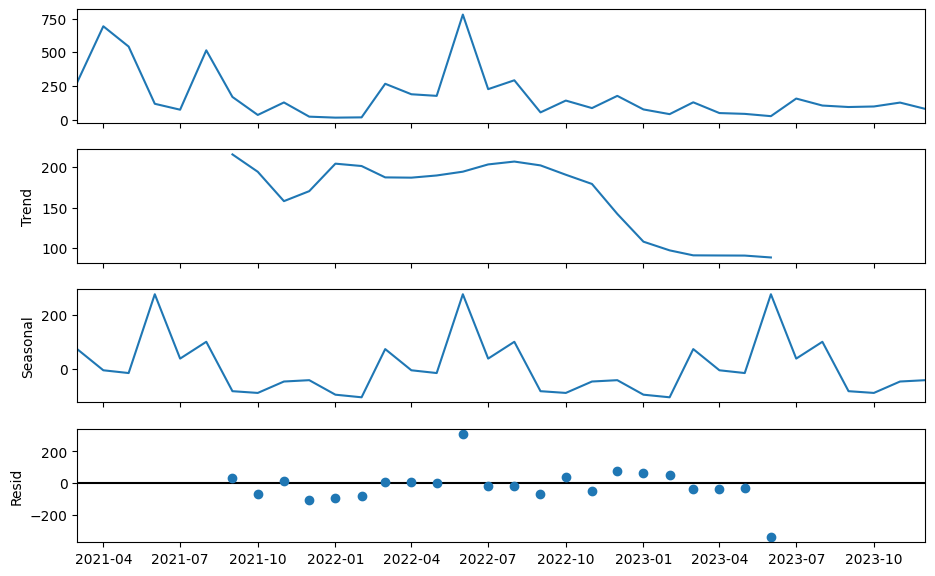

In [149]:
df_fil1 = datos_esco[datos_esco['PKID'] == "B2B0276136"]
df_fil1["Date"] = pd.to_datetime(df_fil1["AnioMes"], format='%Y-%m')
df_pro1 = df_fil1[["Date","CantidadVentaMes"]].set_index('Date')

# Descomponer la serie temporal
decomposition1 = seasonal_decompose(df_pro1, model='additive')
fig = decomposition1.plot()
fig.set_size_inches(10, 6)
plt.show()

- Tendencia: La tendencia muestra una disminución clara desde principios de 2022 hasta mediados de 2023, estabilizándose luego. Es importante capturar esta tendencia en tu modelo.
- Estacionalidad: Hay una estacionalidad clara con un patrón recurrente que se repite aproximadamente cada 12 meses.
- Residuos: Los residuos parecen estar distribuidos de manera uniforme alrededor de cero, lo cual es bueno ya que no muestra patrones evidentes de autocorrelación significativa

Ajustaré un modelo Sarima, ya que este me permite incluir una componente estacional, además de añadir una componente de integración (I) deferente a 0 ya que en la descomposición se observan tendencias, a continuación procedo a entrenar el modelo y pronosticar a 6 meses.

In [141]:
model1 = auto_arima(df_pro1["CantidadVentaMes"],
                   seasonal=True,  # Considerar la componente estacional
                   m=12,           # Periodicidad estacional de 12 meses
                   trace=True)     # Mostrar el progreso del ajuste del modelo

model1.fit(df_pro1["CantidadVentaMes"])

forecast1 = model1.predict(n_periods=6)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=455.775, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=456.147, Time=0.37 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=456.521, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=475.605, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=457.765, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=457.741, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=459.738, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=454.447, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=456.087, Time=0.82 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=456.434, Time=1.46 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=456.398, Time=2.60 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=454.618, Time=1.13 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AI

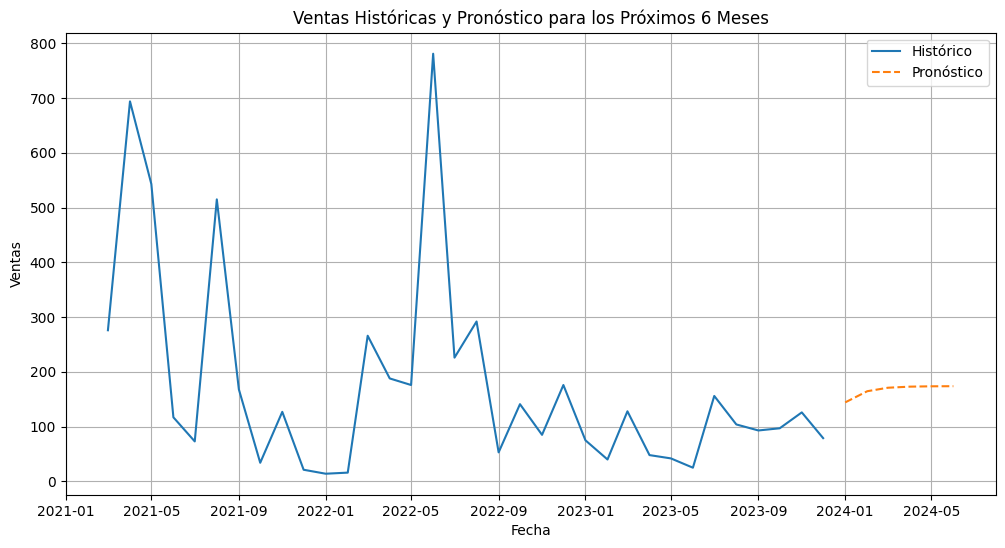

In [143]:
# Crear fechas para los pronósticos
last_date1 = df_pro1.index[-1]
future_dates1 = [last_date1 + pd.DateOffset(months=i) for i in range(1, 6 + 1)]

# Crear DataFrame de pronósticos
df_forecast1 = pd.DataFrame({'Date': future_dates1, 'CantidadVentaMes': forecast1})
df_forecast1.set_index('Date', inplace=True)


# Graficar datos históricos y pronósticos
plt.figure(figsize=(12, 6))
plt.plot(df_pro1.index, df_pro1['CantidadVentaMes'], label='Histórico')
plt.plot(df_forecast1.index, df_forecast1['CantidadVentaMes'], label='Pronóstico', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.title('Ventas Históricas y Pronóstico para los Próximos 6 Meses')
plt.legend()
plt.grid(True)
plt.show()

### B2C0972712

Vamos a aplicar la misma descomposición y verificaremos que modelo o algoritmo utilizar sobre esta serie de tiempo.

In [147]:
df_fil2 = datos_esco[datos_esco['PKID'] == "B2C0972712"]
df_fil2["Date"] = pd.to_datetime(df_fil2["AnioMes"], format='%Y-%m')
df_pro2 = df_fil2[["Date","CantidadVentaMes"]].set_index('Date')
# Establecer la frecuencia del índice
df_pro2 = df_pro2.asfreq('MS')
# Rellenar datos faltantes si es necesario (opcional)
df_pro2 = df_pro2.fillna(method='ffill')  # O usa otro método de interpolación si es adecuado

C:\Users\Brahi\AppData\Local\Temp\ipykernel_13952\944517908.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fil2["Date"] = pd.to_datetime(df_fil2["AnioMes"], format='%Y-%m')


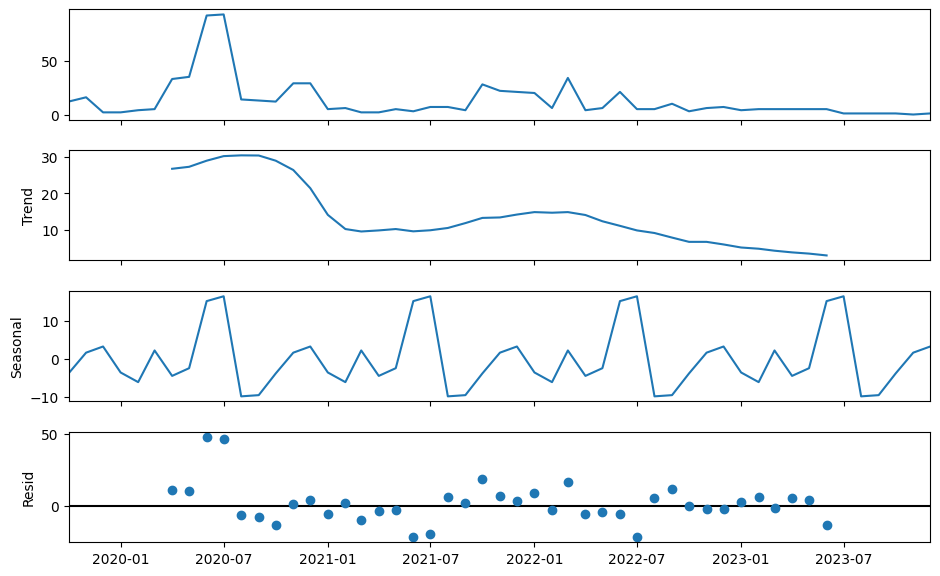

In [175]:
# Descomponer la serie temporal
decomposition2 = seasonal_decompose(df_pro2, model='additive')
fig = decomposition2.plot()
fig.set_size_inches(10, 6)
plt.show()

- Componente de tendencia: Se observa una tendencia que inicialmente es ascendente, luego desciende y finalmente se estabiliza.
- Componente estacional: Hay una componente estacional clara con patrones repetitivos que parecen ocurrir anualmente.
- Componente residual: Los residuos parecen ser pequeños en su mayoría, aunque hay algunos valores atípicos.


Utilizaré nuevamente el modelo SARIMA para añadir la componente estacional que vemos en la descomposición y ajustar la serie para generar pronósticos a 6 meses.

#### Modelo 1

In [183]:
model2 = auto_arima(df_pro2["CantidadVentaMes"],
                   seasonal=True,  # Considerar la componente estacional
                   m=12,           # Periodicidad estacional de 12 meses
                   trace=True,     # Mostrar el progreso del ajuste del modelo
                   stepwise=True)     

model2.fit(df_pro2["CantidadVentaMes"])

forecast2 = model2.predict(n_periods=6)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.49 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=447.409, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=429.695, Time=1.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=426.067, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=465.577, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=425.424, Time=1.08 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=426.620, Time=2.26 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=4.00 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=428.982, Time=0.51 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=427.259, Time=1.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=427.887, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=429.051, Time=1.76 sec
 ARIMA(0,0,1)(0,0,0)[12]             : AIC=433.908, Time=0.17 sec

Best model:  ARIMA(0,0,1)(0,0,0)[12] intercept
Total fit time: 14.666 seconds


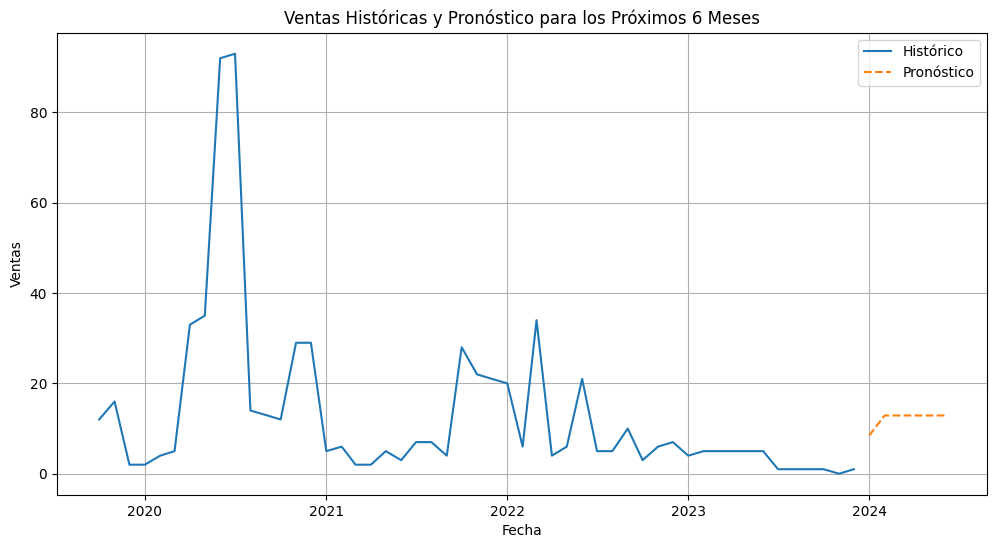

In [184]:
# Crear fechas para los pronósticos
last_date2 = df_pro2.index[-1]
future_dates2 = [last_date2 + pd.DateOffset(months=i) for i in range(1, 6 + 1)]

# Crear DataFrame de pronósticos
df_forecast2 = pd.DataFrame({'Date': future_dates2, 'CantidadVentaMes': forecast2})
df_forecast2.set_index('Date', inplace=True)


# Graficar datos históricos y pronósticos
plt.figure(figsize=(12, 6))
plt.plot(df_pro2.index, df_pro2['CantidadVentaMes'], label='Histórico')
plt.plot(df_forecast2.index, df_forecast2['CantidadVentaMes'], label='Pronóstico', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.title('Ventas Históricas y Pronóstico para los Próximos 6 Meses')
plt.legend()
plt.grid(True)
plt.show()

Ajustaremos un 2do modelo para tratar de comparar los pronósticos y posteriormente seleccionar 1, a continuación procedo a usar el algoritmo de Prophet, este permite también capturar la componente de estacionalidad y tendencias.

#### Modelo 2

In [193]:
df_pro2 = df_pro2.reset_index().rename(columns={'Date': 'ds', 'CantidadVentaMes': 'y'})

In [206]:
# Crear y ajustar el modelo
model = Prophet()
model.fit(df_pro2)

21:23:28 - cmdstanpy - INFO - Chain [1] start processing
21:23:29 - cmdstanpy - INFO - Chain [1] done processing


c:\Users\Brahi\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


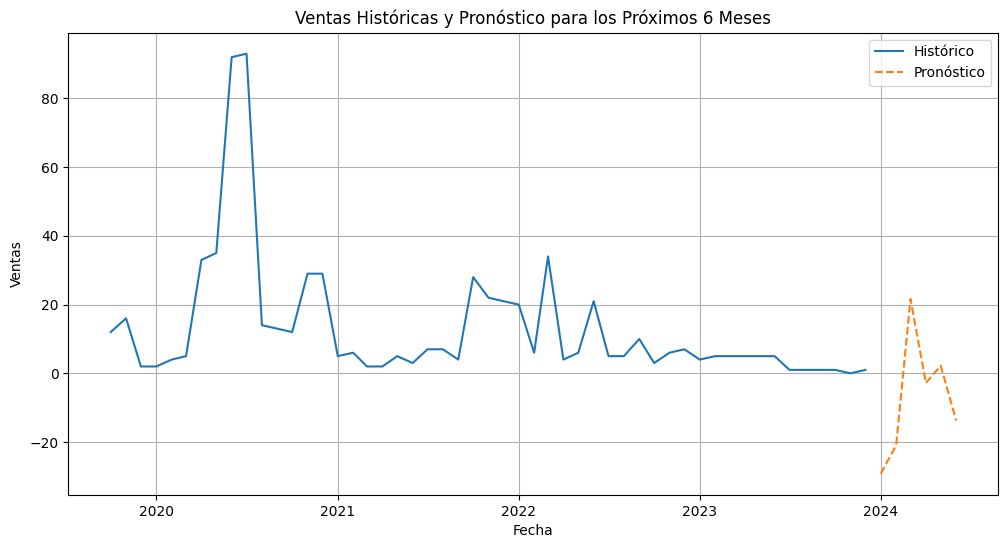

In [221]:
# Crear un DataFrame con las fechas futuras para las que queremos hacer predicciones (6 meses en este caso)
future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)

# Crear fechas para los pronósticos
last_date = df_pro2.ds.max()
future_dates = [last_date + pd.DateOffset(months=i) for i in range(1, 6 + 1)]

# Extraer los pronósticos para los próximos 6 meses
forecast_values = forecast[['ds', 'yhat']].tail(6).set_index('ds')
forecast_values.rename(columns={'yhat': 'CantidadVentaMes'}, inplace=True)

# Crear DataFrame de pronósticos
df_forecast = pd.DataFrame({'Date': future_dates, 'CantidadVentaMes': forecast_values['CantidadVentaMes'].values})
df_forecast.set_index('Date', inplace=True)

# Graficar datos históricos y pronósticos
plt.figure(figsize=(12, 6))
plt.plot(df_pro2.ds, df_pro2['y'], label='Histórico')
plt.plot(df_forecast.index, df_forecast['CantidadVentaMes'], label='Pronóstico', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.title('Ventas Históricas y Pronóstico para los Próximos 6 Meses')
plt.legend()
plt.grid(True)
plt.show()


No escogería este modelo porque en el último tramo de la serie se ve la volatilidad de la serie se estabiliza, mientras que en los pronósticos aumenta, por lo que no estaría interpretando o ajustando este cambio de variabilidad.

### B2C1373778

Por último procedemos a realizar el mismo análisis para este KPID.

C:\Users\Brahi\AppData\Local\Temp\ipykernel_13952\3716777630.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fil3["Date"] = pd.to_datetime(df_fil3["AnioMes"], format='%Y-%m')


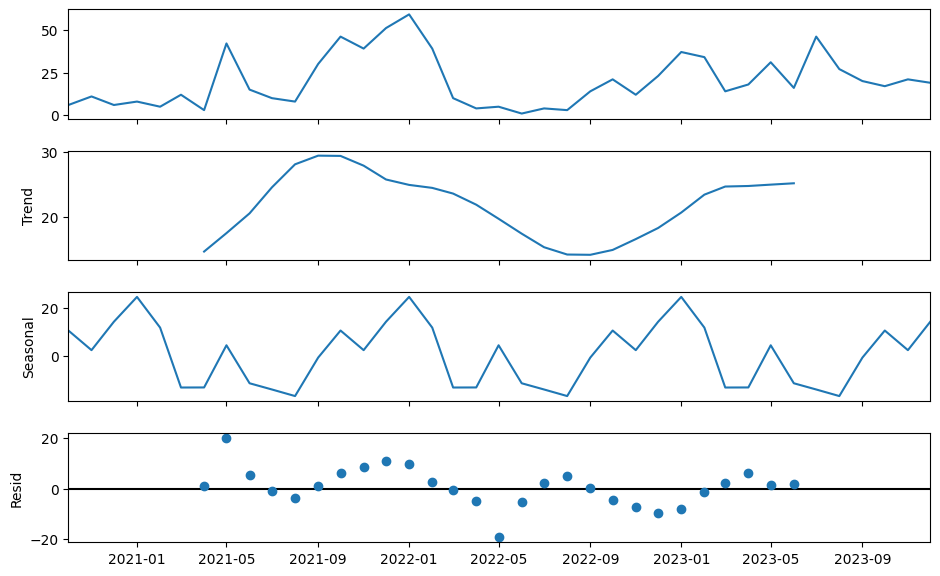

In [157]:
df_fil3 = datos_esco[datos_esco['PKID'] == "B2C1373778"]
df_fil3["Date"] = pd.to_datetime(df_fil3["AnioMes"], format='%Y-%m')
df_pro3 = df_fil3[["Date","CantidadVentaMes"]].set_index('Date')


# Descomponer la serie temporal
decomposition3 = seasonal_decompose(df_pro3, model='additive')
fig = decomposition3.plot()
fig.set_size_inches(10, 6)
plt.show()

- Tendencia: Aumento hasta mediados de 2022 seguido de una disminución.
- Estacionalidad: Patrones repetitivos regulares nuevamente cada año como las anteriores, indican una fuerte componente estacional.
- Residuos: Estan distribuidos alrededor de cero, con algunas variaciones que podrían indicar anomalías.

Dadas estas características nuevamente usaré un modelo SARIMA, las razones de usar este son similares a las anteriores series, básicamente capturar la componente de estacionalidad y de tendencias.

In [158]:
model3 = auto_arima(df_pro3["CantidadVentaMes"],
                   seasonal=True,  # Considerar la componente estacional
                   m=12,           # Periodicidad estacional de 12 meses
                   trace=True)     # Mostrar el progreso del ajuste del modelo

model3.fit(df_pro3["CantidadVentaMes"])

forecast3 = model3.predict(n_periods=6)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=322.441, Time=1.94 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=326.552, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=314.902, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=319.609, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=364.428, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=313.288, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=314.916, Time=0.75 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=316.945, Time=2.63 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=315.284, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=315.285, Time=0.69 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=317.661, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=316.711, Time=1.12 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=318.239, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 8.167 seconds


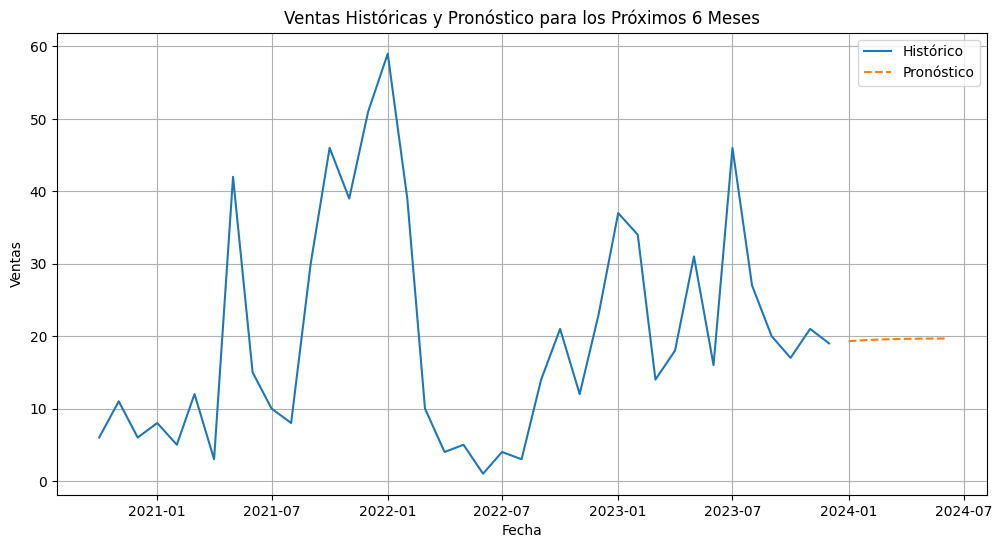

In [159]:
# Crear fechas para los pronósticos
last_date3 = df_pro3.index[-1]
future_dates3 = [last_date3 + pd.DateOffset(months=i) for i in range(1, 6 + 1)]

# Crear DataFrame de pronósticos
df_forecast3 = pd.DataFrame({'Date': future_dates3, 'CantidadVentaMes': forecast3})
df_forecast3.set_index('Date', inplace=True)


# Graficar datos históricos y pronósticos
plt.figure(figsize=(12, 6))
plt.plot(df_pro3.index, df_pro3['CantidadVentaMes'], label='Histórico')
plt.plot(df_forecast3.index, df_forecast3['CantidadVentaMes'], label='Pronóstico', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.title('Ventas Históricas y Pronóstico para los Próximos 6 Meses')
plt.legend()
plt.grid(True)
plt.show()

## Simulaciones junto con los pronósticos

A continuación aplicaremos simulaciones aleatorias del proceso estocástico usando el mismo modelo aplicado que se ejecutaron anteriormente, se harán las simulaciones para cada PKID y observaremos las distintas posibilidades que podría tomar el proceso.

#### B2B0276136

c:\Users\Brahi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Brahi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Brahi\AppData\Local\Temp\ipykernel_13952\1762092661.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=n_steps, freq='M')


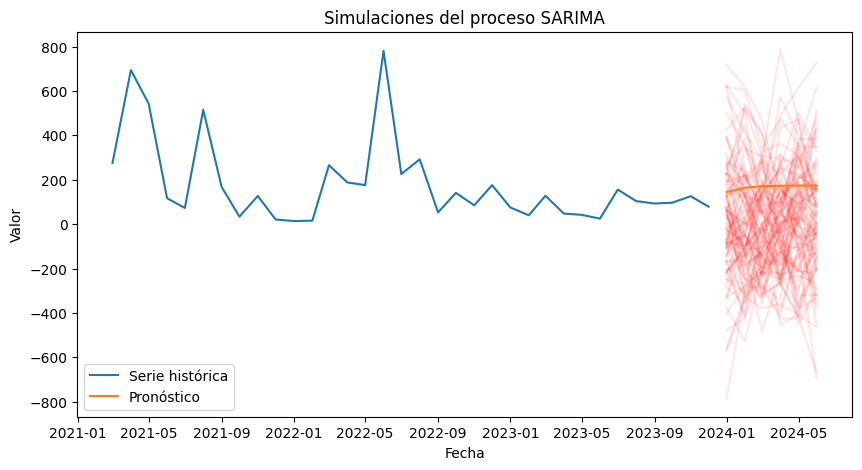

In [237]:
# Ajustar el modelo SARIMA
order = (1, 0, 0)
seasonal_order = (0, 0, 0, 12)  # Aquí puedes ajustar los parámetros de la estacionalidad

model1 = SARIMAX(df_pro1, order=order, seasonal_order=seasonal_order)
model_fit1 = model1.fit()

# Simular varias realizaciones
n_steps = 6  # Número de pasos a predecir
n_realizations = 100  # Número de realizaciones
realizations1 = []

for _ in range(n_realizations):
    # Generar una nueva realización utilizando el modelo ajustado
    realization1 = model_fit1.simulate(nsimulations=n_steps)
    realizations1.append(realization1)

realizations1 = np.array(realizations1)
# Crear un nuevo índice de años para las realizaciones
last_date = df_pro2.index[-1]
future_dates = pd.date_range(start=last_date, periods=n_steps, freq='M')

# Visualizar la serie original y las predicciones
plt.figure(figsize=(10, 5))
plt.plot(df_pro1, label='Serie histórica')

# Graficar cada realización con el nuevo índice de fechas
for realization in realizations1:
    plt.plot(future_dates, realization, color='red', alpha=0.1)

# Supongo que df_forecast1 contiene el pronóstico, asegúrate de tenerlo disponible
plt.plot(df_forecast1.index, df_forecast1['CantidadVentaMes'], label='Pronóstico', linestyle="-")

plt.title('Simulaciones del proceso SARIMA')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

#### B2C0972712

In [232]:
# Restableciendo el estado en el que estaba df_fil2 para poder ejecutar el código
df_fil2 = datos_esco[datos_esco['PKID'] == "B2C0972712"]
df_fil2["Date"] = pd.to_datetime(df_fil2["AnioMes"], format='%Y-%m')
df_pro2 = df_fil2[["Date","CantidadVentaMes"]].set_index('Date')
df_pro2 = df_pro2.asfreq('MS')
df_pro2 = df_pro2.fillna(method='ffill') 

C:\Users\Brahi\AppData\Local\Temp\ipykernel_13952\2022838376.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fil2["Date"] = pd.to_datetime(df_fil2["AnioMes"], format='%Y-%m')
C:\Users\Brahi\AppData\Local\Temp\ipykernel_13952\2022838376.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_pro2 = df_pro2.fillna(method='ffill')


C:\Users\Brahi\AppData\Local\Temp\ipykernel_13952\1300707746.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=n_steps, freq='M')


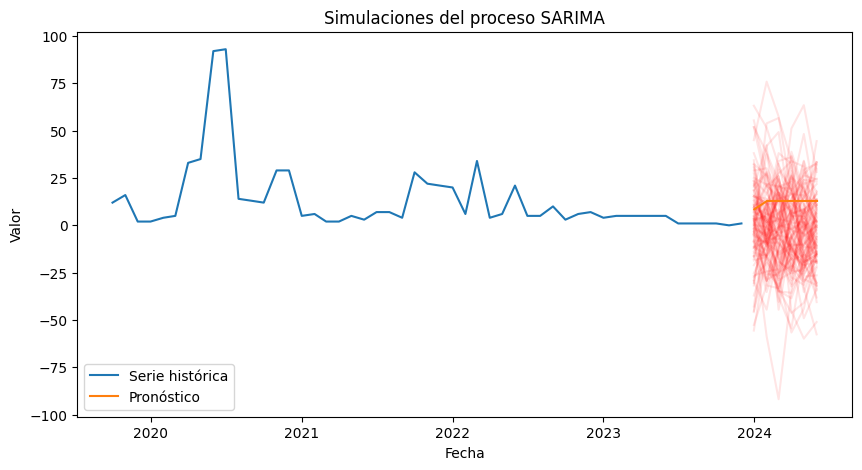

In [234]:
# Ajustar el modelo SARIMA
order = (0,0,1)
seasonal_order = (0, 0, 0, 12)  # Ajusta los parámetros de estacionalidad según tus datos y análisis

model2 = SARIMAX(df_pro2, order=order, seasonal_order=seasonal_order)
model_fit2 = model2.fit()

# Simular varias realizaciones
n_steps = 6  # Número de pasos a predecir
n_realizations = 100  # Número de realizaciones
realizations2 = []

for _ in range(n_realizations):
    # Generar una nueva realización utilizando el modelo ajustado
    realization2 = model_fit2.simulate(nsimulations=n_steps)
    realizations2.append(realization2)

realizations2 = np.array(realizations2)
# Crear un nuevo índice de años para las realizaciones
last_date = df_pro2.index[-1]
future_dates = pd.date_range(start=last_date, periods=n_steps, freq='M')

# Visualizar la serie original y las predicciones
plt.figure(figsize=(10, 5))
plt.plot(df_pro2, label='Serie histórica')

# Graficar cada realización con el nuevo índice de fechas
for realization in realizations2:
    plt.plot(future_dates, realization, color='red', alpha=0.1)

# Supongo que df_forecast2 contiene el pronóstico, asegúrate de tenerlo disponible
plt.plot(df_forecast2.index, df_forecast2['CantidadVentaMes'], label='Pronóstico', linestyle="-")

plt.title('Simulaciones del proceso SARIMA')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

#### B2C1373778

c:\Users\Brahi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Brahi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Brahi\AppData\Local\Temp\ipykernel_13952\1641975293.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=n_steps, freq='M')


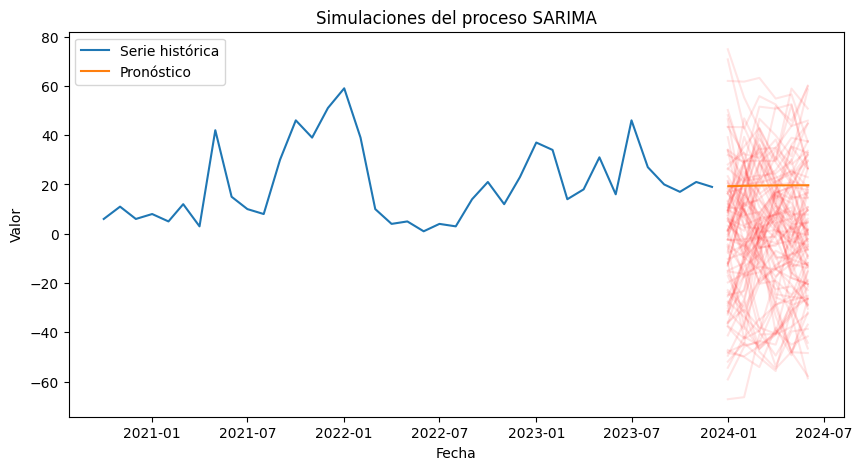

In [231]:
# Ajustar el modelo SARIMA
order = (1, 0, 0)
seasonal_order = (0, 0, 0, 12)  # Ajusta los parámetros de estacionalidad según tus datos y análisis

model3 = SARIMAX(df_pro3, order=order, seasonal_order=seasonal_order)
model_fit3 = model3.fit()

# Simular varias realizaciones
n_steps = 6  # Número de pasos a predecir
n_realizations = 100  # Número de realizaciones
realizations3 = []

for _ in range(n_realizations):
    # Generar una nueva realización utilizando el modelo ajustado
    realization3 = model_fit3.simulate(nsimulations=n_steps)
    realizations3.append(realization3)

realizations3 = np.array(realizations3)
# Crear un nuevo índice de años para las realizaciones
last_date = df_pro3.index[-1]
future_dates = pd.date_range(start=last_date, periods=n_steps, freq='M')

# Visualizar la serie original y las predicciones
plt.figure(figsize=(10, 5))
plt.plot(df_pro3, label='Serie histórica')

# Graficar cada realización con el nuevo índice de fechas
for realization in realizations3:
    plt.plot(future_dates, realization, color='red', alpha=0.1)

# Supongo que df_forecast3 contiene el pronóstico, asegúrate de tenerlo disponible
plt.plot(df_forecast3.index, df_forecast3['CantidadVentaMes'], label='Pronóstico', linestyle="-")

plt.title('Simulaciones del proceso SARIMA')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()


Vemos que claramente donde la volatilidad es más alta, las simulaciones son en rangos más anchos, a diferencia de cuando las volatilidades son menores.

## Error cuadrático medio (MSE) 

In [243]:
# Valores observados
y_true1 = df_pro1["CantidadVentaMes"][-6:].values

# Valores pronosticados
y_pred1 = forecast1

# Calcular el Error Cuadrático Medio
mse1 = mean_squared_error(y_true1, y_pred1)

# Calcular el Error Cuadrático Medio
rmse1 = np.sqrt(mse1)

print("Error Cuadrático Medio:", mse1)
print("Raíz del Error Cuadrático Medio:", rmse1)

Error Cuadrático Medio: 4491.349437407429
Raíz del Error Cuadrático Medio: 67.01753082147557


In [246]:
# Valores observados
y_true2 = df_pro2["CantidadVentaMes"][-6:].values

# Valores pronosticados
y_pred2 = forecast2

# Calcular el Error Cuadrático Medio
mse2 = mean_squared_error(y_true2, y_pred2)

# Calcular el Error Cuadrático Medio
rmse2 = np.sqrt(mse2)

print("Error Cuadrático Medio:", mse2)
print("Raíz del Error Cuadrático Medio:", rmse2)

Error Cuadrático Medio: 131.3751518498992
Raíz del Error Cuadrático Medio: 11.46190001046507


In [247]:
# Valores observados
y_true3 = df_pro3["CantidadVentaMes"][-6:].values

# Valores pronosticados
y_pred3 = forecast3

# Calcular el Error Cuadrático Medio
mse3 = mean_squared_error(y_true3, y_pred3)

# Calcular el Error Cuadrático Medio
rmse3 = np.sqrt(mse3)

print("Error Cuadrático Medio:", mse3)
print("Raíz del Error Cuadrático Medio:", rmse3)

Error Cuadrático Medio: 129.80537620745721
Raíz del Error Cuadrático Medio: 11.393216236316118


Analizando los errores cuadráticos medios pareciera que en los últimos modelos ajustan los valores reales, es decir tiene un comportamiento que puede ser aceptable, se puede recomendar a mi trabajo ajustar nuevos modelos como RNN o más parametrizaciones en los modelos ARIMA y lograr un mejor performance de los modelos y los pronósticos.

## ¿Cómo se puede implementar una estrategia analítica que permita pronosticar las ventas de todo el portafolio de la compañía? 
Claramente, pronosticar ventas para cada KPDI es un trabajo arduo que lleva tiempo de parte del analista, por otro lado, muchas series a pesar de ser distintas tiene componentes similares, tal vez se puede buscar un modelo que pueda capturar estas similitudes entre las componentes, entrenar y obtener los parámetros para cada KPID del modelo y lanzar pronósticos para cada KPDI y pronosticar ventas para todo el portafolio de la compañía. 

#### Conclusiones generales.

Una conclusión importante que me llevo de este ejercicio y del análisis realizado es que todas las series para cada PKID son diferentes. Es decir, las tendencias pueden variar dependiendo de factores internos. Más allá de que algunos factores, como la pandemia, afectaron las ventas de muchos PKID, no siempre serán factores externos los que influyan.

Otra conclusión es que en la descomposición se notaron estacionalidades constantes cada año, muy claramente en los PKID. Aunque los ciclos entre cada PKID comenzaban en fechas distintas, estas estacionalidades son importantes porque permiten prever, en cada PKID, las fechas donde se pueden impulsar iniciativas de publicidad y ventas en los picos para aumentar ganancias. Con esto se sabe que, en estos puntos, las ventas suelen incrementarse en ciertas temporadas del año.



Muchas gracias